<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/LSTNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F 
import requests
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from torch.utils.data import TensorDataset,DataLoader   
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
import matplotlib.pyplot as plt

# get model
res =requests.get('https://raw.githubusercontent.com/skywalker0803r/LSTNet.pytorch/master/LSTNet.py').text
exec(res)
model = LSTNet()

# get data
start,end = datetime.datetime(2010,1,1),datetime.date.today()
df = web.DataReader("AAPL", "yahoo", start, end).drop('Adj Close',axis=1)
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0
2010-01-05,7.699643,7.616071,7.664286,7.656428,601904800.0
2010-01-06,7.686786,7.526786,7.656428,7.534643,552160000.0
2010-01-07,7.571429,7.466072,7.562500,7.520714,477131200.0
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0


In [2]:
def make_data_iter(df,ss_x,time_step=48):
  data = {'x':[],'y':[]}
  for t in range(len(df)-time_step):
    data['x'].append(ss_x.transform(df.iloc[t:t+time_step,:].values))
    data['y'].append(df.iloc[[t+time_step],:][['Close']].values)
  data['x'] = np.array(data['x'])
  data['y'] = np.array(data['y'])
  print(data['x'].shape,data['y'].shape)
  data = TensorDataset(torch.FloatTensor(data['x']),torch.FloatTensor(data['y']))
  data_iter = DataLoader(data,batch_size=64)
  return data_iter

def split_df(df):
  sp1 = int(len(df)*0.8)
  sp2 = int(len(df)*0.9)
  train = df.iloc[:sp1]
  valid = df.iloc[sp1:sp2]
  test = df.iloc[sp2:]
  return train,valid,test

In [3]:
# split data
train,valid,test = split_df(df)
# use train_data make scaler
ss_x = StandardScaler().fit(train)
# apply scaler and make data_iter
train_iter = make_data_iter(train,ss_x)
valid_iter = make_data_iter(valid,ss_x)
test_iter = make_data_iter(test,ss_x)

(2147, 48, 5) (2147, 1, 1)
(226, 48, 5) (226, 1, 1)
(227, 48, 5) (227, 1, 1)


# test model

In [4]:
for x,y in train_iter:
  y = y.reshape(-1,1)
  print(x.shape,y.shape)
  y_hat = model(x)
  print(y_hat.shape)
  break

torch.Size([64, 48, 5]) torch.Size([64, 1])
torch.Size([64, 1])


# loss and optimizer

In [5]:
loss_fn = lambda a,b:((a-b)**2).mean()
optimizer = Adam(model.parameters(),lr=0.001)

# train_loop

In [6]:
def train_loop(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y.reshape(-1,1))
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = deepcopy(net.eval())
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 665.9963 valid loss 2002.5440
record net
epochs 1 train loss 482.7258 valid loss 1704.4414
record net
epochs 2 train loss 359.4556 valid loss 1352.6567
record net
epochs 3 train loss 254.9034 valid loss 1029.6650
record net
epochs 4 train loss 183.4424 valid loss 809.6982
record net
epochs 5 train loss 139.1019 valid loss 640.0190
record net
epochs 6 train loss 102.5355 valid loss 504.9164
record net
epochs 7 train loss 75.8129 valid loss 400.7491
record net
epochs 8 train loss 57.2167 valid loss 317.7824
record net
epochs 9 train loss 42.4057 valid loss 259.5779
record net
epochs 10 train loss 34.0830 valid loss 213.1422
record net
epochs 11 train loss 27.6077 valid loss 182.5580
record net
epochs 12 train loss 22.8744 valid loss 156.0316
record net
epochs 13 train loss 20.6212 valid loss 137.9532
record net
epochs 14 train loss 18.2775 valid loss 123.5505
record net
epochs 15 train loss 19.7118 valid loss 128.8131
epochs 16 train loss 17.6804 valid loss 108.7878
r

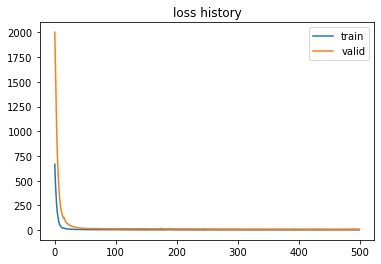

In [7]:
best_model = train_loop(model,train_iter,valid_iter,loss_fn,optimizer,num_epochs=500)

In [8]:
def evaluate(model,data_iter):
  x = data_iter.dataset.tensors[0]
  y = data_iter.dataset.tensors[1]
  y_hat = model(x)
  y_hat = y_hat.detach().numpy().reshape(-1,1)
  y_real = y.detach().numpy().reshape(-1,1)
  plt.plot(y_hat,label='y_hat')
  plt.plot(y_real,label='y_real')
  plt.legend()
  plt.show()

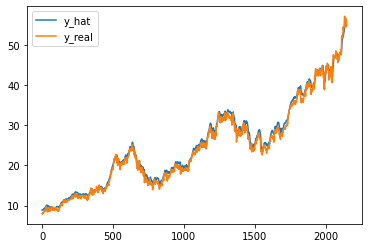

In [9]:
evaluate(best_model,train_iter)

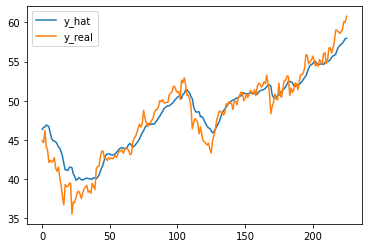

In [10]:
evaluate(best_model,valid_iter)

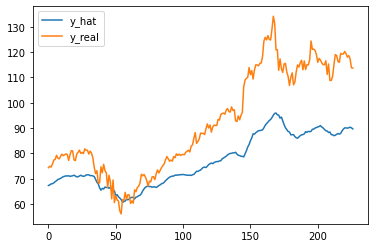

In [11]:
evaluate(best_model,test_iter)